
# Try out Bayesian update to environmental estimate


In [2]:

# %%
#%%
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
import scipy.stats as stats
import seaborn as sns
import xarray as xr
import arviz as az
import arviz.labels as azl
from hierarchical_normal_belk import hierarchical_normal
import itertools
#!! conda install -c conda-forge flox
import flox
from flox.xarray import xarray_reduce # useful in doing multiple coord groupings


In [3]:
rng=np.random.Generator(np.random.PCG64(1234))


In [4]:
size = 160 #size of grid
horz_offest = 10 #offset of grid from 0,0
mean_tempC_Km = 6.5/1000 #mean lapse rate
max_alt_Km = 13 #max altitude in km
#keep lat and long square for ease of matrixing
lat = np.arange(horz_offest, size)
long = np.arange(0, size - horz_offest)
alt = np.arange(0, max_alt_Km)*1000 #in meters


In [5]:
# AR is auto-regressive, MA is moving average; will only use AR 
def sample_AR_signal(n_samples, corr, mu=0, sigma=1):
    assert 0 < corr < 1, "Auto-correlation must be between 0 and 1"
    burn_samples = 100
    n_samples=n_samples+burn_samples

    # Find out the offset `c` and the std of the white noise `sigma_e`
    # that produce a signal with the desired mean and variance.
    # See https://en.wikipedia.org/wiki/Autoregressive_model
    # under section "Example: An AR(1) process".
    c = mu * (1 - corr)
    sigma_e = np.sqrt((sigma ** 2) * (1 - corr ** 2))

    # Sample the auto-regressive process.
    signal = [c + np.random.normal(0, sigma_e)]
    for _ in range(1, n_samples):
        signal.append(c + corr * signal[-1] + np.random.normal(0, sigma_e))
    
    return np.array(signal[burn_samples:])
    
def compute_corr_lag_1(signal):
    return np.corrcoef(signal[:-1], signal[1:])[0][1]



# Baseline thermal along latitude




In [266]:
base_sigma = .005
samp_lat_base = sample_AR_signal(size-horz_offest, 0.5, mu=2, sigma=base_sigma)
samp_lat= pd.DataFrame(samp_lat_base)
print(compute_corr_lag_1(samp_lat_base), samp_lat)


0.6145913587034996             0
0    1.995289
1    1.993730
2    1.998051
3    1.998500
4    1.993427
..        ...
145  1.999971
146  2.002679
147  2.000252
148  2.007878
149  2.009261

[150 rows x 1 columns]



# Extend along longitude


In [267]:
#use latitudes as mean for AR signal along longitudes
samp = sample_AR_signal(size-horz_offest, 0.75, mu=samp_lat, sigma=base_sigma)
samp = pd.DataFrame(samp[:, :, 0])
print(compute_corr_lag_1(samp.iloc[:,0]),compute_corr_lag_1(samp.iloc[0,:]))


0.7408422226291976 0.6145913587034993


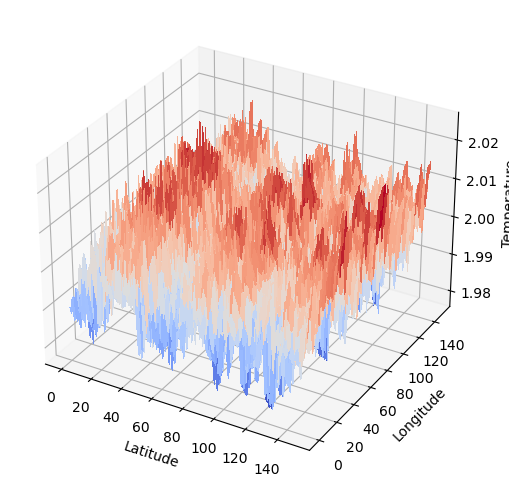

In [268]:

def plot_temperature_env(samp):
    x2, y2 = np.meshgrid(samp.index.values, samp.columns.values)
    plt.figure(figsize=(6,5))
    axes = plt.axes(projection='3d')
    axes.plot_surface(x2, y2,samp.values,cmap=cm.coolwarm,
                          linewidth=0, antialiased=False)
    axes.set_ylabel('Longitude')
    axes.set_xlabel('Latitude')
    axes.set_zlabel('Temperature')
    # keeps padding between figure elements
    plt.tight_layout()
    plt.show()

plot_temperature_env(samp)


# Add trend on top of the AR variation -- to baseline thermal


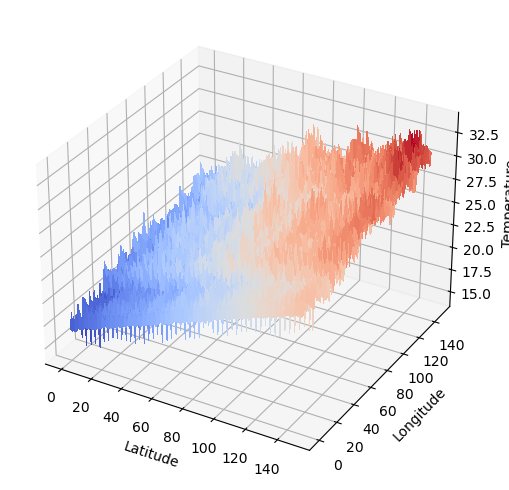

In [269]:
# add MA
lat_inc_slope = 10/size  #deterministic slope of increase in temperature with latitude
lat_inc_max = lat_inc_slope *(size-horz_offest) 
long_inc_mu, long_inc_std = 5/size, .1  #mean and std of increase in temperature with longitude

def add_inc_MA(size, horz_offest, sample_AR_signal, samp_lat, lat_inc_max, long_inc_mu, long_inc_std):
    lat_inc = np.linspace(0,lat_inc_max, len(samp_lat))
    sample_lat_inc = samp_lat[0] + lat_inc
    sample_lat_inc = pd.DataFrame(sample_lat_inc)
#sample_lat_inc.plot()

    samp_inc = sample_AR_signal(size-horz_offest, corr=0.5, mu=sample_lat_inc)
    long_inc = stats.norm.rvs(loc=long_inc_mu, scale=long_inc_std, size=(size-horz_offest,size-horz_offest), random_state=None)
    long_inc = np.cumsum(long_inc, axis=0)
    samp_inc = pd.DataFrame(samp_inc[:, :, 0]+long_inc)
    return samp_inc

samp_inc = add_inc_MA(size, horz_offest, sample_AR_signal, samp_lat, lat_inc_max, long_inc_mu, long_inc_std)
#bump temperature up to standard atmosphere
samp_inc=samp_inc+15

plot_temperature_env(samp_inc)



# Extend into atmosphere


In [299]:

#allow for inversion by having random lapse rate at diff altitudes
def add_altitude_effects(rng, samp_inc, mean_tempC_Km, max_alt_Km):
    tempC_Km = rng.normal(loc=mean_tempC_Km, scale=mean_tempC_Km/100, size=max_alt_Km)
# Temp at altitude = base temp - tempC_km * altitude
    temperature = ( [np.array(samp_inc) 
                 for _ in np.arange(max_alt_Km)]
               -np.broadcast_to(
    tempC_Km * alt, (size-horz_offest,size-horz_offest,max_alt_Km)
    ).T
)
    temperature = temperature.T
    return temperature

temp_3D = add_altitude_effects(rng, samp_inc, mean_tempC_Km, max_alt_Km)


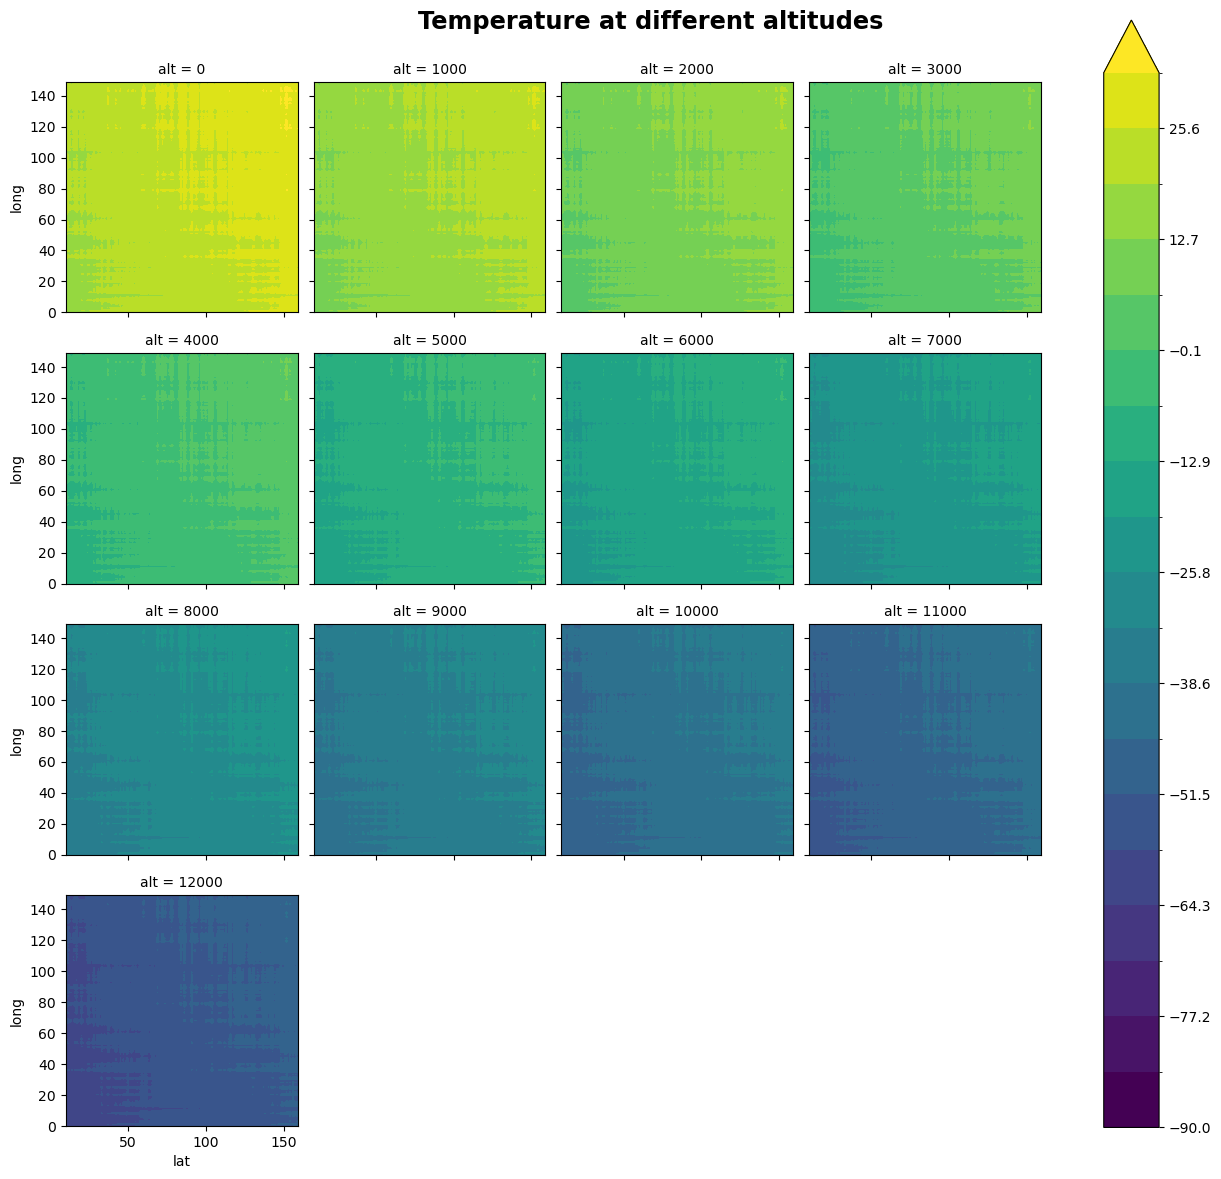

In [300]:

xr_temp_3D = xr.DataArray(temp_3D, dims=['lat', 'long', 'alt'], coords={'lat': lat, 'long': long, 'alt': alt})
fig = xr_temp_3D.plot.contourf(x='lat',y='long',col='alt', col_wrap=4,
                         robust=True, vmin=-90, vmax=32, levels=20)
plt.suptitle('Temperature at different altitudes', fontsize = 'xx-large',
             weight = 'extra bold')
plt.subplots_adjust(top=.92, right=.8, left=.05, bottom=.05)

xr_tempC_Km=  xr.DataArray(mean_tempC_Km, dims=['alt'], coords={'alt': alt})



# Calculate pressure based on baseline temp field and assumed L; 


In [301]:

#barometric formula
def add_barometric_effects(T = 288.15-273.15, L = 0.0065, H = 0,  P0 = 101_325.00, g0 = 9.80665, M = 0.0289644, R = 8.3144598):
    #barometric formula
    #P = P0 * (1 - L * H / T0) ^ (g0 * M / (R * L))
    #P = pressure
    #P0 = pressure at sea level = 101_325.00 Pa
    #L = temperature lapse rate = temperature lapse rate (K/m) in
    #H = altitude (m)
    #T0 = temperature at sea level = reference temperature (K)
    #g0 = gravitational acceleration = gravitational acceleration: 9.80665 m/s2
    #M = molar mass of air = molar mass of Earth's air: 0.0289644 kg/mol
    #R = gas constant = universal gas constant: 8.3144598 J/(mol·K)
    #L = temperature lapse rate
    #T = temperature
    T = T +273.15
    if isinstance(T, xr.core.dataarray.DataArray):
        T0 = T.sel(alt=0)
        
    else:
        T0 = T[0]
        print('used t[0]')
        print(type(T))
    #return P0 * (1 - L * H / (T0+273.15)) ** (g0 * M / (R * L))
    #return P0 * (1 + L * H / (T0+273.15)) ** (-g0 * M / (R * L))
    return P0 * (1 + (-L)*H/ T0) ** (-g0 * M / (R * (-L)))


pressure = add_barometric_effects(T = xr_temp_3D, 
                                 L = mean_tempC_Km, 
                                 H = xr_temp_3D.alt,  P0 = 101_325.00, g0 = 9.80665, M = 0.0289644, R = 8.3144598)


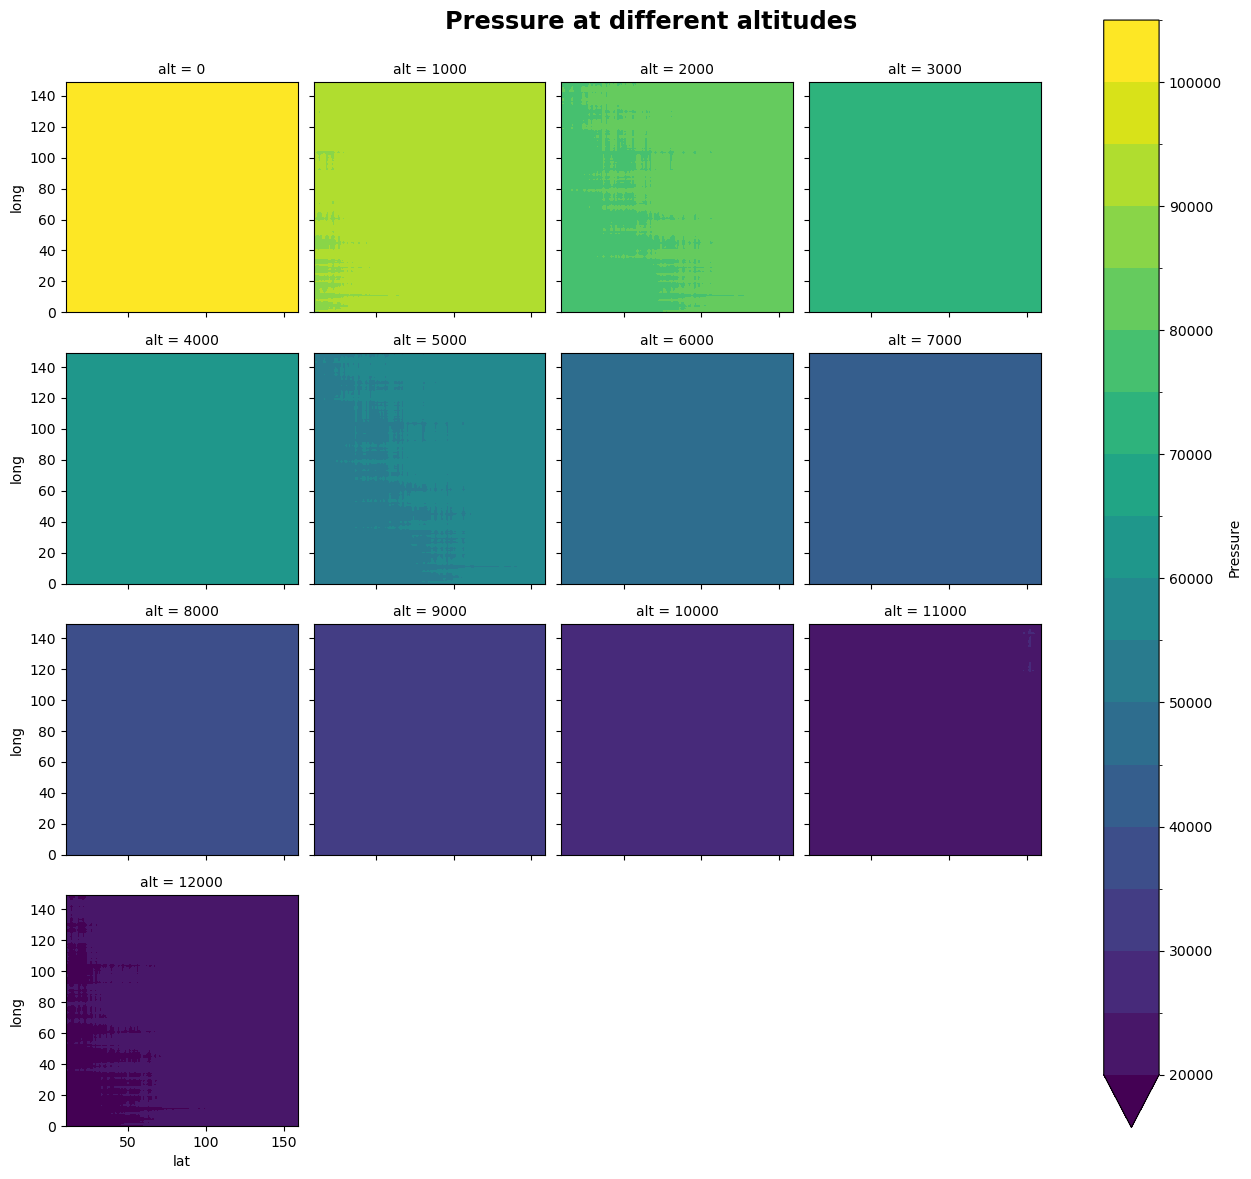

In [302]:

xr_temp_pres = xr.merge(
    [xr_temp_3D.rename("Temperature"), 
     pressure.rename("Pressure")]
     )

xr_temp_pres.Pressure.plot.contourf(x='lat',y='long', col='alt', col_wrap=4,
                         robust=True, levels=20)
plt.suptitle('Pressure at different altitudes', fontsize = 'xx-large',
             weight = 'extra bold')
plt.subplots_adjust(top=.92, right=.8, left=.05, bottom=.05)


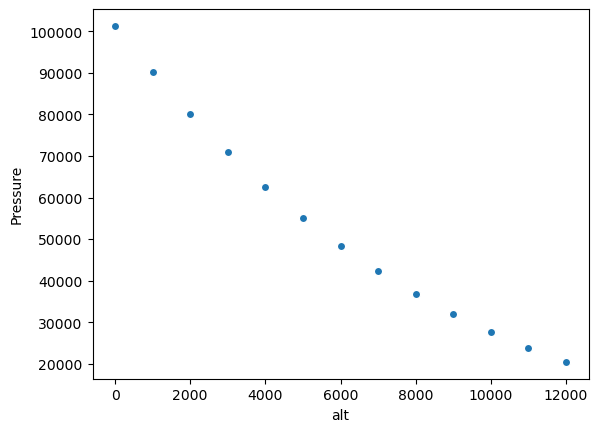

In [303]:
xr_temp_pres.mean(['lat', 'long']).plot.scatter(x='alt', y='Pressure')


# # make trajectory and get corresponding temp and pres


In [304]:
# make Z = a function of time and  X = sin of time and y = cos of time
time = pd.to_datetime( np.arange(0, 3*60*60, 1), unit='s')
print(time)


DatetimeIndex(['1970-01-01 00:00:00', '1970-01-01 00:00:01',
               '1970-01-01 00:00:02', '1970-01-01 00:00:03',
               '1970-01-01 00:00:04', '1970-01-01 00:00:05',
               '1970-01-01 00:00:06', '1970-01-01 00:00:07',
               '1970-01-01 00:00:08', '1970-01-01 00:00:09',
               ...
               '1970-01-01 02:59:50', '1970-01-01 02:59:51',
               '1970-01-01 02:59:52', '1970-01-01 02:59:53',
               '1970-01-01 02:59:54', '1970-01-01 02:59:55',
               '1970-01-01 02:59:56', '1970-01-01 02:59:57',
               '1970-01-01 02:59:58', '1970-01-01 02:59:59'],
              dtype='datetime64[ns]', length=10800, freq=None)


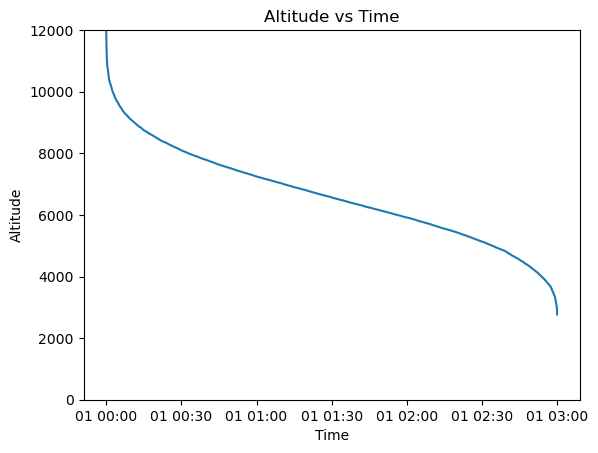

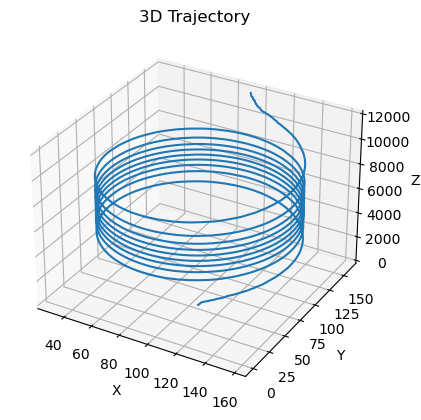

In [305]:

release_alt = 12_000 #Troposphere goes to about 12Km, thermal is about linear there
step_alt = 1
turn_rate = 3.14 #turns per hour
x = (np.sin((time.hour+time.minute/60 +time.second/3600)*(2*np.pi)*turn_rate) +1) * size/2.50 +30
y = (np.cos((time.hour+time.minute/60 +time.second/3600)*(2*np.pi)*turn_rate) +1 ) * size/2
#create samples from normal distribution and sort them
samples = stats.weibull_max.rvs(2.9, loc=0, scale=1, size=len(time), random_state=None)
samples.sort()
steps = samples/(samples.max()-samples.min()) /1.3  #normalize and shrink
steps = steps - steps.min() #shift to 0
 #smaller step per time
z = release_alt * (1- steps)

plt.plot(time, z)
plt.xlabel('Time')
plt.ylabel('Altitude')
plt.title('Altitude vs Time')
ax = plt.gca()
ax.set_ylim(0, 12000)
plt.show()
#plot 3d trajectory of z by x and y
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(x, y, z)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.set_zlim(0, 12000)
plt.title('3D Trajectory')
plt.show()


In [306]:

#select from xarray the temperature at the pressure of the trajectory
xr_traj_env = xr.DataArray()

xr_x = xr.DataArray(x, dims=['time'], coords={'time': time})
xr_y = xr.DataArray(y, dims=['time'], coords={'time': time})
xr_z = xr.DataArray(z, dims=['time'], coords={'time': time})

xr_traj_env = xr_temp_pres.interp(lat=xr_x,long=xr_y,alt=xr_z)#, method='nearest')
xr_traj_env = xr_traj_env.interpolate_na(dim='time', method='linear', fill_value="extrapolate")
xr_traj_env.attrs =dict(units='seconds since 1970-01-01 00:00:00')
 # delay start of trajectory
xr_traj_env['time'] = xr_traj_env.time +pd.Timedelta(hours=.75)

xr_traj_env


<xarray.Dataset>
Dimensions:      (time: 10800)
Coordinates:
    long         (time) float64 160.0 160.0 160.0 160.0 ... 10.54 10.32 10.11
    alt          (time) float64 1.2e+04 1.181e+04 ... 2.789e+03 2.769e+03
  * time         (time) datetime64[ns] 1970-01-01T00:45:00 ... 1970-01-01T03:...
    lat          (time) float64 94.0 94.35 94.7 95.05 ... 125.8 125.4 125.1
Data variables:
    Temperature  (time) float64 2.43 1.991 1.551 1.112 ... 3.138 4.225 4.867
    Pressure     (time) float64 3.119e+04 3.115e+04 ... 7.275e+04 7.297e+04
Attributes:
    units:    seconds since 1970-01-01 00:00:00


# Put in Ballon data


In [307]:

ballon_alt_samples = np.arange(start=0,stop=max_alt_Km*1000+1,step=500)
ballon_time = ballon_alt_samples/5
ballon_time = pd.to_datetime(  ballon_time, unit='s')
ballon_lat = [40, 80, 41, 139, 140]
ballon_long = [15, 100, 140, 139, 25]
launch_count = len(ballon_lat)
ballon_delay = [pd.Timedelta(hours=i)
                for i in [0,5,6.5,8,9]
                ]# 7*60*60 # 7 hrs later in seconds
launch_idx = np.arange(0,launch_count)
def ballon_release(xr_temp_pres, ballon_alt_samples, ballon_time, ballon_lat, ballon_long, ballon_delay, launch_idx):
    #ballon launch delay is in hours, will convert number to pd.Timedelta
    #ballon_delay = pd.Timedelta(hours=ballon_delay)
    coords={'launch':[launch_idx],'time':(('time'),ballon_time+ballon_delay)}
    xr_ballon_env = xr_temp_pres.interp(lat=
                                    xr.DataArray([[ballon_lat[launch_idx]]]*len(ballon_time), 
                                                 dims=['time','launch'],
                                                 coords=coords),
                                    long=
                                    xr.DataArray([[ballon_long[launch_idx]]]*len(ballon_time)
                                    ,
                                                 dims=['time','launch'],
                                                 coords=coords),
                                    alt=
                                    xr.DataArray([ballon_alt_samples],
                                                 dims=['launch','time'],
                                                 coords=coords),
                                    )
    xr_ballon_env= xr_ballon_env.interpolate_na(dim='time',method='linear', fill_value = 'extrapolate')
    xr_ballon_env.attrs =dict(units='seconds since 1970-01-01 00:00:00')
    return xr_ballon_env

#TODO: remove the 'launch' dimension from the ballon_release function, then do not squeeze it out
xr_ballon_env_lst = [ballon_release(xr_temp_pres, ballon_alt_samples, ballon_time,

                                 ballon_lat, ballon_long, ballon_delay[i], launch_idx=i).squeeze()
                                   for i in np.arange(launch_count)

                    ]
xr_ballon_env = xr.concat(xr_ballon_env_lst, dim='time')



xr_ballon_env


<xarray.Dataset>
Dimensions:      (time: 135)
Coordinates:
    long         (time) int32 15 15 15 15 15 15 15 15 ... 25 25 25 25 25 25 25
    alt          (time) int32 0 500 1000 1500 2000 ... 11500 12000 12500 13000
    launch       (time) int32 0 0 0 0 0 0 0 0 0 0 0 0 ... 4 4 4 4 4 4 4 4 4 4 4
  * time         (time) datetime64[ns] 1970-01-01 ... 1970-01-01T09:43:20
    lat          (time) int32 40 40 40 40 40 40 40 ... 140 140 140 140 140 140
Data variables:
    Temperature  (time) float64 19.8 16.59 13.38 10.06 ... -51.41 -54.99 -58.58
    Pressure     (time) float64 1.013e+05 9.569e+04 ... 1.909e+04 1.739e+04
Attributes:
    units:    seconds since 1970-01-01 00:00:00

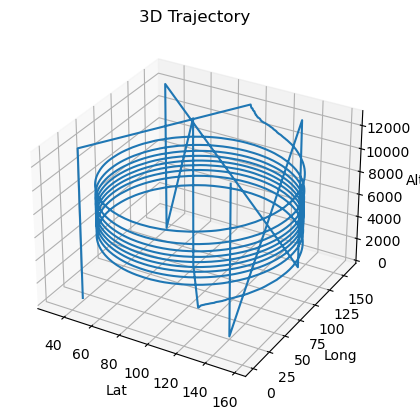

In [308]:

xr_traj_env = xr.concat([xr_traj_env, 
                         xr_ballon_env.drop('launch')],
                           dim='time').sortby('time')
#plot 3d trajectory of z by x and y

def plot_traj_3d(xarray=None):
    xr_x= xarray
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(xr_x.lat,
            xr_x.long,
            xr_x.alt)
    ax.set_xlabel('Lat')
    ax.set_ylabel('Long')
    ax.set_zlabel('Alt')
    ax.set_zlim(0, xr_x.alt.max())
    plt.title('3D Trajectory')
    plt.show()

 

plot_traj_3d(xr_traj_env)

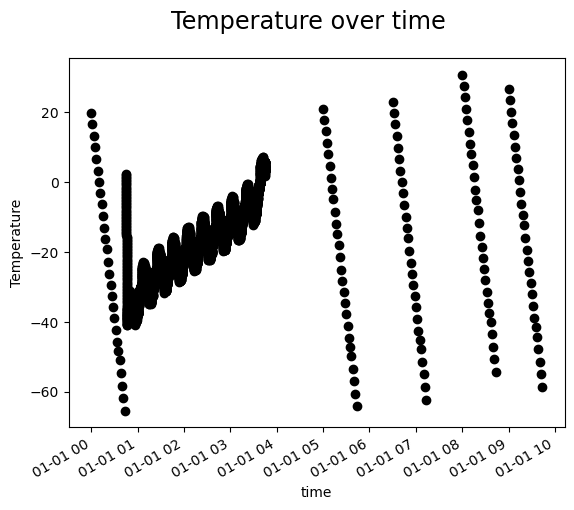

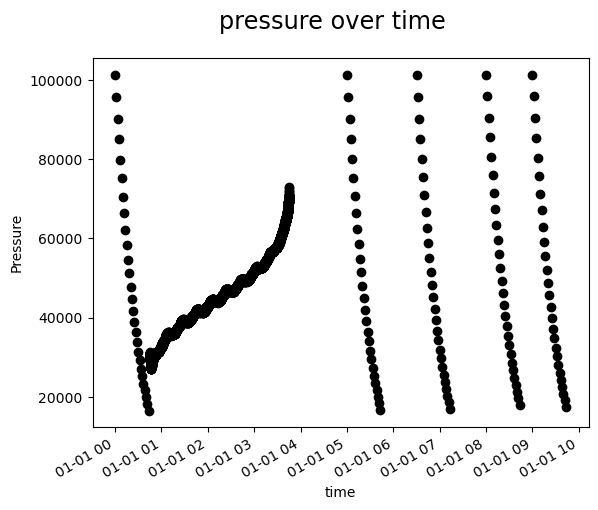

In [309]:

xr_traj_env.Temperature.plot.scatter(x='time',color='black')
plt.suptitle('Temperature over time', fontsize = 'xx-large')
plt.show()
#make each dot black
xr_traj_env.Pressure.plot.scatter(x='time', y='Pressure', color='black')
plt.suptitle('pressure over time', fontsize = 'xx-large')
plt.show()



# downsample from xarray


In [310]:
xr_traj_env.reset_coords(['lat','long','alt'], drop=False).resample(time='5min', restore_coord_dims=True
                                                                    ).mean().dropna(dim='time'
                                                                                    ).set_coords(['lat','long','alt']
                                                                                                 ).set_xindex(['alt','lat','long'])



<xarray.Dataset>
Dimensions:      (time: 81)
Coordinates:
  * time         (time) object MultiIndex
  * alt          (time) float64 500.0 2e+03 3.5e+03 ... 9.5e+03 1.1e+04 1.25e+04
  * lat          (time) float64 40.0 40.0 40.0 40.0 ... 140.0 140.0 140.0 140.0
  * long         (time) float64 15.0 15.0 15.0 15.0 15.0 ... 25.0 25.0 25.0 25.0
Data variables:
    Temperature  (time) float64 16.59 6.717 -3.1 -13.06 ... -35.54 -44.55 -54.99
    Pressure     (time) float64 9.569e+04 7.998e+04 ... 2.428e+04 1.909e+04
Attributes:
    units:    seconds since 1970-01-01 00:00:00

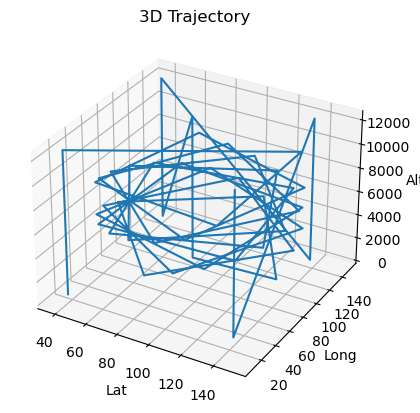

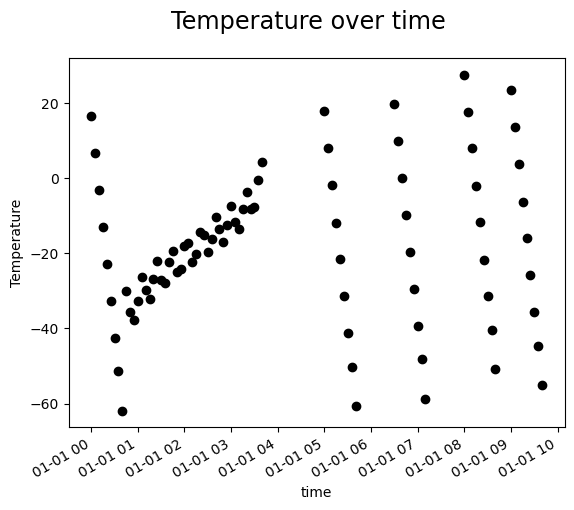

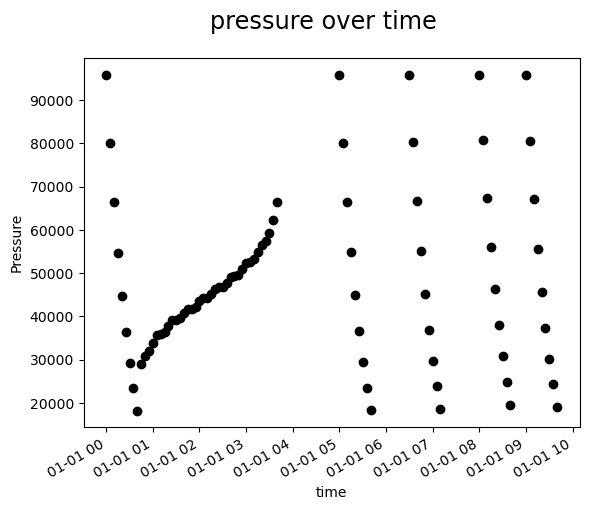

In [311]:

#must be a datetime index in xarray
# move xarray coordinate to variable
xr_traj_env_time = xr_traj_env.reset_coords(['lat','long','alt'], drop=False)
xr_traj_env_time = xr_traj_env_time.resample(time='5min', restore_coord_dims=True).mean().dropna(dim='time')
xr_traj_env_time_coords = xr_traj_env_time.copy(deep=True)
#Move variable to xarray coordinate multiindex
xr_traj_env_time= xr_traj_env.reset_coords(['lat','long','alt'], drop=False
                                           ).resample(time='5min', restore_coord_dims=True
                                                      ).mean().dropna(dim='time'
                                                                      ).set_coords(['lat','long','alt']
                                                                                   ).set_xindex(['alt','lat','long'])

'''#this duplicates the data :(
xr_traj_env_time = xr_traj_env_time.drop(['lat','long','alt'])
xr_traj_env_time = xr_traj_env_time.expand_dims({"lat":xr_traj_env_time_coords.lat.values, 
                              'long':xr_traj_env_time_coords.long.values, 
                              'alt':xr_traj_env_time_coords.alt.values}) '''


plot_traj_3d(xr_traj_env_time)
plt.show()

xr_traj_env_time_coords.Temperature.plot.scatter(x='time',color='black')
plt.suptitle('Temperature over time', fontsize = 'xx-large')
plt.show()
#make each dot black
xr_traj_env_time_coords.Pressure.plot.scatter(x='time', y='Pressure', color='black')
plt.suptitle('pressure over time', fontsize = 'xx-large')
plt.show()
# toDO CHANGE THIS VARIABLE BELOW HERE
#xarray make a multiindex of lat long alt and time

#grp_traj_env = 
# may be useful : xr_traj_env_time.stack(alt_lat_long_time=['alt','lat','long','time'],create_index=True)


In [312]:
#xr_traj_env_time wher Temperature is between 26 and 27 degrees
xr_traj_env_time.sel( lat=40.0, long=15.0)#[0,:,:,0]

<xarray.Dataset>
Dimensions:      (alt: 9)
Coordinates:
  * alt          (alt) float64 500.0 2e+03 3.5e+03 ... 9.5e+03 1.1e+04 1.25e+04
    lat          float64 40.0
    long         float64 15.0
Data variables:
    Temperature  (alt) float64 16.59 6.717 -3.1 -13.06 ... -42.41 -51.41 -61.86
    Pressure     (alt) float64 9.569e+04 7.998e+04 ... 2.336e+04 1.822e+04
Attributes:
    units:    seconds since 1970-01-01 00:00:00


# # Using average values per time period along release; TODO: find more principled way to remove autocorrelation 



# # Model temp and pressure varying by altitude, lat, & long


In [313]:
#standardize the data

def standardize(xarray=None):
    xr_x = xarray
    revert_mean, revert_std = xr_x.mean(), xr_x.std()
    xr_x = (xr_x - xr_x.mean()) / xr_x.std()
    return xr_x, revert_mean, revert_std
def revert_standardize(xarray=None, revert_mean=None, revert_std=None):
    xr_x = xarray
    xr_x = xr_x * revert_std + revert_mean
    return xr_x

xr_traj_env_time['stz_lat'], sdz_mean, stz_std = standardize(xr_traj_env_time.lat)
xr_traj_env_time.attrs['sdz_lat_mean'] =sdz_mean.values
xr_traj_env_time.attrs['sdz_lat_std']  =stz_std.values
xr_traj_env_time['stz_long'], sdz_mean, stz_std = standardize(xr_traj_env_time.long)
xr_traj_env_time.attrs['sdz_long_mean'] =sdz_mean.values
xr_traj_env_time.attrs['sdz_long_std']  =stz_std.values
xr_traj_env_time['stz_alt'], sdz_mean, stz_std = standardize(xr_traj_env_time.alt)
xr_traj_env_time.attrs['sdz_alt_mean'] =sdz_mean.values
xr_traj_env_time.attrs['sdz_alt_std']  =stz_std.values

xr_traj_env_time

<xarray.Dataset>
Dimensions:      (time: 81)
Coordinates:
  * time         (time) object MultiIndex
  * alt          (time) float64 500.0 2e+03 3.5e+03 ... 9.5e+03 1.1e+04 1.25e+04
  * lat          (time) float64 40.0 40.0 40.0 40.0 ... 140.0 140.0 140.0 140.0
  * long         (time) float64 15.0 15.0 15.0 15.0 15.0 ... 25.0 25.0 25.0 25.0
Data variables:
    Temperature  (time) float64 16.59 6.717 -3.1 -13.06 ... -35.54 -44.55 -54.99
    Pressure     (time) float64 9.569e+04 7.998e+04 ... 2.428e+04 1.909e+04
    stz_lat      (time) float64 -1.201 -1.201 -1.201 ... 1.128 1.128 1.128
    stz_long     (time) float64 -1.286 -1.286 -1.286 ... -1.095 -1.095 -1.095
    stz_alt      (time) float64 -1.982 -1.491 -0.9999 ... 0.9647 1.456 1.947
Attributes:
    units:          seconds since 1970-01-01 00:00:00
    sdz_lat_mean:   91.5677475249025
    sdz_lat_std:    42.93433677159304
    sdz_long_mean:  82.40360109412816
    sdz_long_std:   52.413127904119584
    sdz_alt_mean:   6553.790219881034
    sdz_alt_std:    3053.991958418555

In [314]:
print(xr_traj_env_time.sel(alt=2000))

<xarray.Dataset>
Dimensions:      (time: 5)
Coordinates:
  * time         (time) object MultiIndex
  * lat          (time) float64 40.0 80.0 41.0 139.0 140.0
  * long         (time) float64 15.0 100.0 140.0 139.0 25.0
    alt          float64 2e+03
Data variables:
    Temperature  (time) float64 6.717 7.971 9.883 17.77 13.58
    Pressure     (time) float64 7.998e+04 8.006e+04 ... 8.068e+04 8.042e+04
    stz_lat      (time) float64 -1.201 -0.2694 -1.178 1.105 1.128
    stz_long     (time) float64 -1.286 0.3357 1.099 1.08 -1.095
    stz_alt      (time) float64 -1.491 -1.491 -1.491 -1.491 -1.491
Attributes:
    units:          seconds since 1970-01-01 00:00:00
    sdz_lat_mean:   91.5677475249025
    sdz_lat_std:    42.93433677159304
    sdz_long_mean:  82.40360109412816
    sdz_long_std:   52.413127904119584
    sdz_alt_mean:   6553.790219881034
    sdz_alt_std:    3053.991958418555


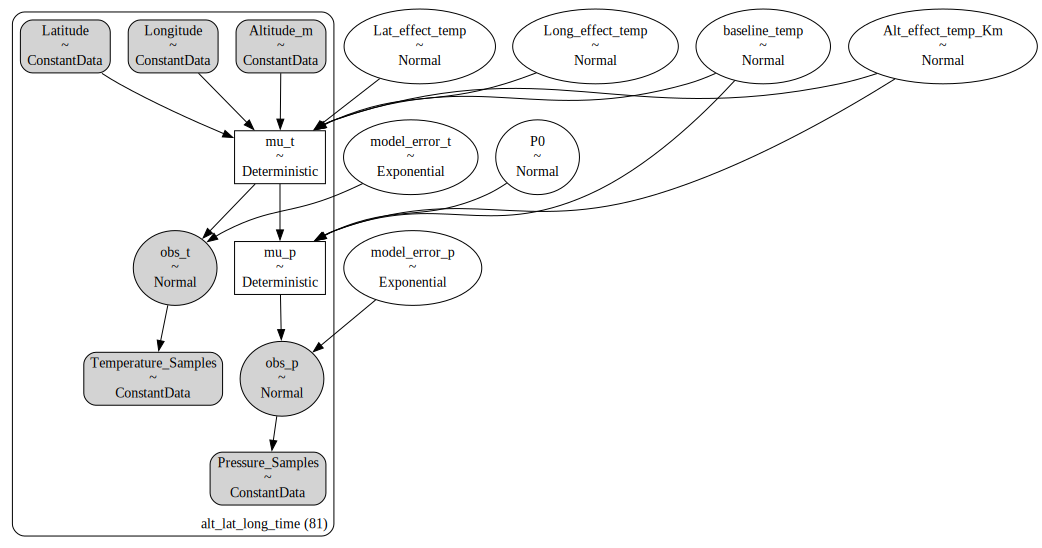

In [330]:

coords={'alt_lat_long_time':
                      np.arange(xr_traj_env_time.sizes['time'], dtype=int)
                      }
with pm.Model(coords=coords) as thermal_pres:
    #Temp is in celcius
    
    Alt_ = pm.ConstantData('Altitude_m', xr_traj_env_time.alt.values,# use normal unstabdardized data
                                          dims='alt_lat_long_time' )
    Lat_ = pm.ConstantData('Latitude', xr_traj_env_time.stz_lat.values,# [bin_item.mid for bin_item in grp_traj_env.lat_bins.values],
                                        dims='alt_lat_long_time' )
    Long_ = pm.ConstantData('Longitude', xr_traj_env_time.stz_long.values,#[bin_item.mid for bin_item in grp_traj_env.long_bins.values],
                                          dims='alt_lat_long_time' )
    Temp_ = pm.ConstantData('Temperature_Samples', xr_traj_env_time.Temperature.values, dims='alt_lat_long_time' )
    Pres_ = pm.ConstantData('Pressure_Samples', xr_traj_env_time.Pressure.values, dims='alt_lat_long_time' )
    #prior on effect on temp (degC) of altitude and lat, long
    baseline_temp = pm.Normal('baseline_temp', mu=15, sigma=3) #'L'
    Alt_effect_temp = pm.Normal('Alt_effect_temp_Km', mu=-6, sigma=0.5)
    Lat_effect_temp = pm.Normal('Lat_effect_temp', mu=0, sigma=10/12)
    Long_effect_temp = pm.Normal('Long_effect_temp', mu=0, sigma=10/12)
    Lat_Long_effect_temp = 0  #pm.Normal('Lat_Long_effect_temp', mu=0, sigma=1)
    #prior on temp and pressure
    #TODO: PULL FROM DATABASE into a pm.Interpolated...maybe not: need relationship between data spreads?
    mu_t = pm.Deterministic('mu_t',
                               baseline_temp + 
                               Alt_effect_temp/1000 * Alt_ + 
                               Lat_effect_temp * Lat_ + 
                               Long_effect_temp * Long_ + 
                               Lat_Long_effect_temp * Lat_ * Long_, 
                               dims='alt_lat_long_time')
    #mu_t = hierarchical_normal('temperature_mean', mu= mu_mu_t, sigma = 2, dims='alt_lat_long_time')
    #mu_p = hierarchical_normal('pressure_mean', 
    P0 = pm.Normal('P0', mu=1, sigma=.01)*101_325.00 # Pres_[0]#101_325.00
    g0 = 9.80665
    M = 0.0289644
    R = 8.3144598
    # NOTE: Temp_[0] is not the lowest altitude tempreture, but the first tempreture in the array
    Temp_0 = baseline_temp#pm.Normal('T0', mu=1, sigma=.01)*15
    mu_p= pm.Deterministic('mu_p',P0 *  ((mu_t+273.15)/(Temp_0+273.15)) ** (-g0 * M / (R * (Alt_effect_temp/1000))), #needed negative b/c the lapse is positive, but use addition in effect
                                 dims='alt_lat_long_time')
    '''add_barometric_effects(T = mu_t,#Temp_, 
                                 L = Alt_effect_temp/1000, H = Alt_,  
                                 P0 = 101_325.00, g0 = 9.80665, M = 0.0289644, R = 8.3144598)'''
    #add_barometric_effects = P0 * (T/T0) ** (g0 * M / (R * L))
    #prior on error variation
    sigma_t=pm.Exponential('model_error_t', 1/5)
    sigma_p=pm.Exponential('model_error_p', 1/1000)
    #adjusted temp - normal dist error term
    obs_t = pm.Normal('obs_t', mu=mu_t, sigma=sigma_t, 
                    observed = Temp_, dims='alt_lat_long_time')
    obs_p = pm.Normal('obs_p', mu=mu_p, sigma=sigma_p, observed = Pres_, dims='alt_lat_long_time')
    
pm.model_to_graphviz(thermal_pres)


## Examine the priors selected and their match to the observed

Sampling: [Alt_effect_temp_Km, Lat_effect_temp, Long_effect_temp, P0, baseline_temp, model_error_p, model_error_t, obs_p, obs_t]


array([<Axes: xlabel='obs_t / obs_t'>, <Axes: xlabel='obs_p / obs_p'>],
      dtype=object)

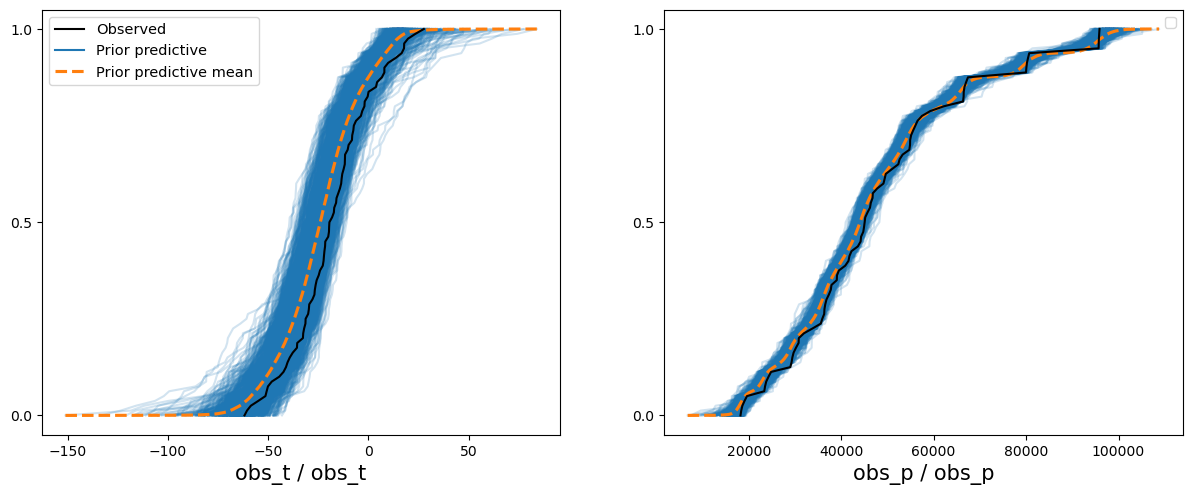

In [331]:
with thermal_pres:
    idata = pm.sample_prior_predictive(1000)
az.plot_ppc(idata, group='prior', kind='cumulative')


## Run MCMC bayesian sampler

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Initializing NUTS using jitter+adapt_diag...


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 35 seconds.


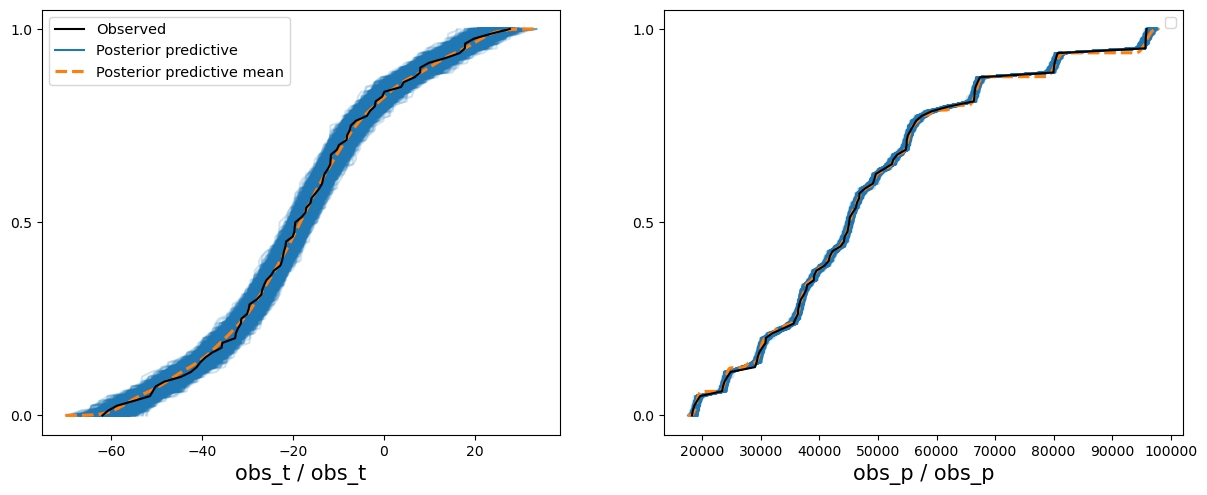

In [332]:
with thermal_pres:
    idata.extend(pm.sample(1000, tune=1000, chains = 4, cores=1))
    # pymc sample posterior predictive check
    pm.sample_posterior_predictive(idata, extend_inferencedata=True)
    az.plot_ppc(idata, group='posterior', kind='cumulative')

In [333]:
#As i am going to be messing with coordinates and attributes, i am going to make a copy of the data
idata2 = idata.copy()

In [334]:
long_inc_mu

0.03125

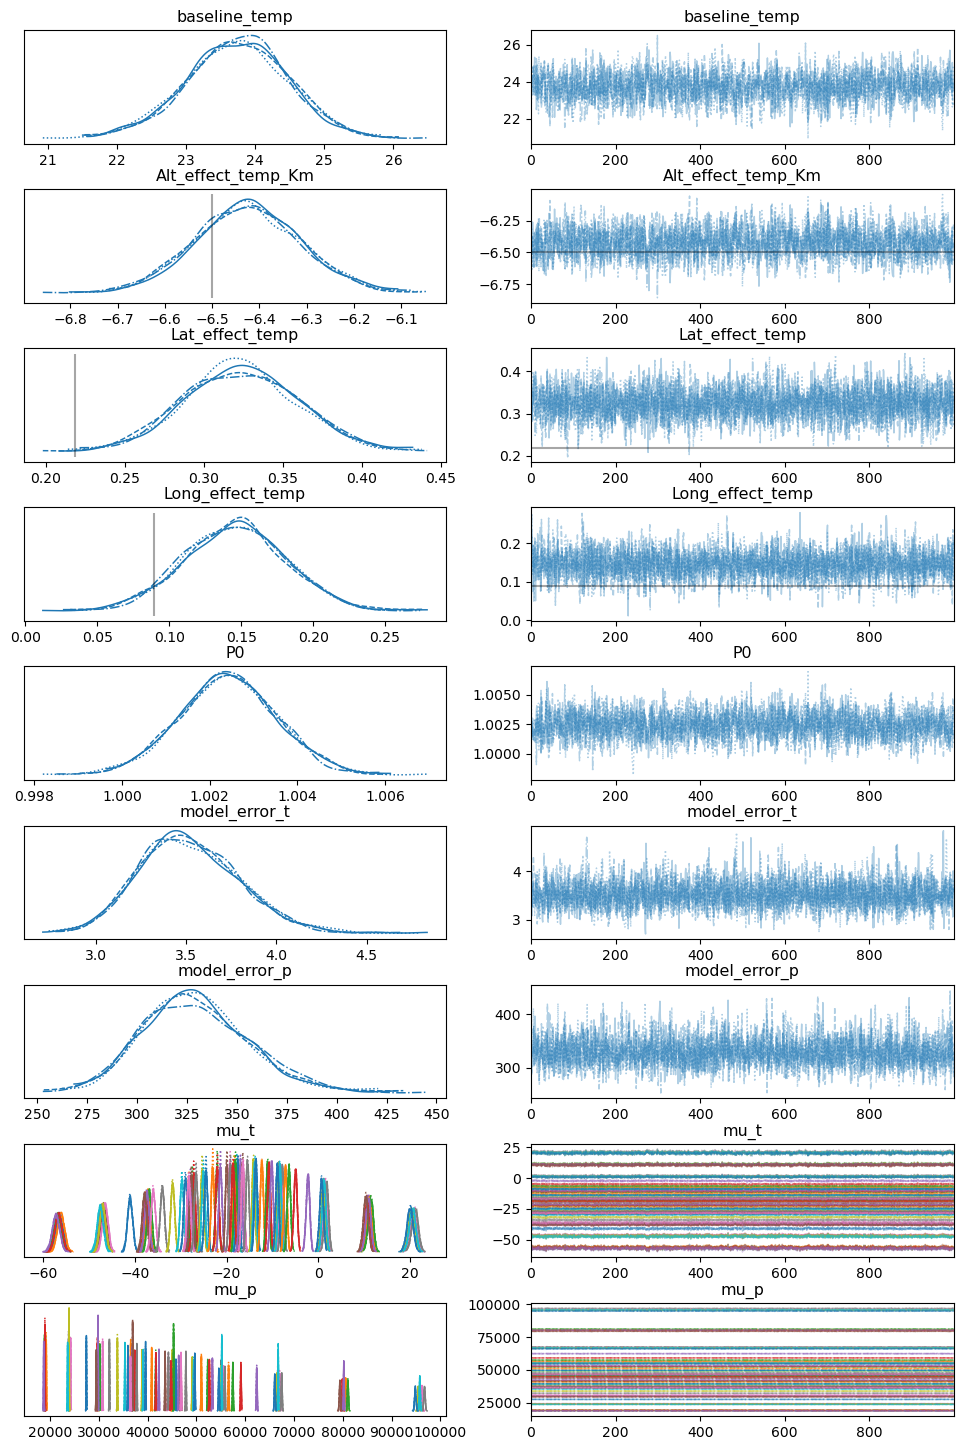

In [361]:
correctsignsize_mean_tempC_Km= -mean_tempC_Km*1000
az.plot_trace(idata2, lines = (('Alt_effect_temp_Km', {},[correctsignsize_mean_tempC_Km]),
                              #('Lat_effect_temp',{}, lat_inc_slope  ),
                              #('Long_effect_temp',{}, long_inc_mu  ), ))
                              #('Lat_effect_temp',{}, lat_inc_slope / xr_traj_env_time_scaled.attrs['sdz_lat_std'] ),
                              #('Long_effect_temp',{}, long_inc_mu / xr_traj_env_time_scaled.attrs['sdz_long_std'] ), ))
                              ('Lat_effect_temp',{}, lat_inc_slope  *(size-  horz_offest)/ xr_traj_env_time.attrs['sdz_lat_std'] ),  
                              ('Long_effect_temp',{}, long_inc_mu *(size-  horz_offest)/ xr_traj_env_time.attrs['sdz_long_std'] ), ))

plt.subplots_adjust (hspace=0.4)#, wspace=0.4)

In [360]:
xr_traj_env_time.attrs['sdz_long_std'] * long_inc_mu
lat_inc_slope  * (4)#*xr_traj_env_time.attrs['sdz_lat_std'] )/xr_traj_env_time.attrs['sdz_lat_std'] 
long_inc_mu * 4
lat_inc_slope  * (size-  horz_offest)/xr_traj_env_time.attrs['sdz_lat_std'] 

0.2183566978074959

In [336]:
idata2.posterior_predictive.drop_indexes('alt_lat_long_time')

<xarray.Dataset>
Dimensions:            (chain: 4, draw: 1000, alt_lat_long_time: 81)
Coordinates:
  * chain              (chain) int32 0 1 2 3
  * draw               (draw) int32 0 1 2 3 4 5 6 ... 994 995 996 997 998 999
    alt_lat_long_time  (alt_lat_long_time) int32 0 1 2 3 4 5 ... 76 77 78 79 80
Data variables:
    obs_t              (chain, draw, alt_lat_long_time) float64 14.61 ... -58.08
    obs_p              (chain, draw, alt_lat_long_time) float64 9.528e+04 ......
Attributes:
    created_at:                 2023-04-30T05:55:46.080354
    arviz_version:              0.15.1
    inference_library:          pymc
    inference_library_version:  5.2.0

In [337]:
sortby_alt = xr.DataArray(idata2.constant_data.Altitude_m.values,
                                              coords={'alt_lat_long_time':idata2.constant_data.alt_lat_long_time.values})
idata2 = idata2.map(lambda ds, **kwarg: ds.sortby(**kwarg), groups= ["~sample_stats"],variables=sortby_alt, ascending=False)
idata2 = idata2.map(lambda ds, **kwarg: ds.assign_coords(**kwarg), 
           groups=['prior_predictive', 'posterior_predictive', 'observed_data'], 
           Altitude_m=(['alt_lat_long_time'], idata2.constant_data.Altitude_m.values))
'''idata2.posterior = idata2.posterior.sortby( sortby_alt, ascending=False) #posterior only for now
idata2.constant_data = idata2.constant_data.sortby( sortby_alt, ascending=False)#( ['Altitude_m', 'Latitude','Longitude'], ascending=False)#('Altitude_m', ascending=False)
'''
idx_sortby_alt = idata2.constant_data.alt_lat_long_time.values


In [338]:
#xarray filter by values - used in grouping graphs
lat_min = idata2.constant_data.Latitude.min()
lat_max = idata2.constant_data.Latitude.max()
long_min = idata2.constant_data.Longitude.min()
long_max = idata2.constant_data.Longitude.max()
lat_mid = (lat_min + lat_max)/2
long_mid = (long_min + long_max)/2

idx_north = idata2.constant_data.where(idata2.constant_data.Latitude>lat_mid, drop=True).alt_lat_long_time.values
idx_south = idata2.constant_data.where(idata2.constant_data.Latitude<lat_mid, drop=True).alt_lat_long_time.values
idx_east = idata2.constant_data.where(idata2.constant_data.Longitude>long_mid, drop=True).alt_lat_long_time.values
idx_west = idata2.constant_data.where(idata2.constant_data.Longitude<long_mid, drop=True).alt_lat_long_time.values


In [339]:
# creating class for labeling the altitude instead of variable index
class DimCoordLabeller_alt(azl.BaseLabeller):
    """WIP."""
    def __init__(self, coords_ds):
        self.coords_ds = xr.Dataset(coords)

    def dim_coord_to_str(self, dim, coord_val, coord_idx):
        """WIP."""#format decimals in f statement
        temp =  self.coords_ds.sel(pointwise_sel=coord_val).items()
        temp = [(v.values) for _,v in temp][0]
        return f"{temp:.2f}" 
    
coords = {
    'alt_lat_long_time': xr.DataArray(
        idata2.constant_data.Altitude_m.values, 
        dims=['pointwise_sel'],coords={'pointwise_sel': idata2.constant_data.alt_lat_long_time.values}
    )
}        
labeller = DimCoordLabeller_alt(coords)


North West
North East
South West
South East


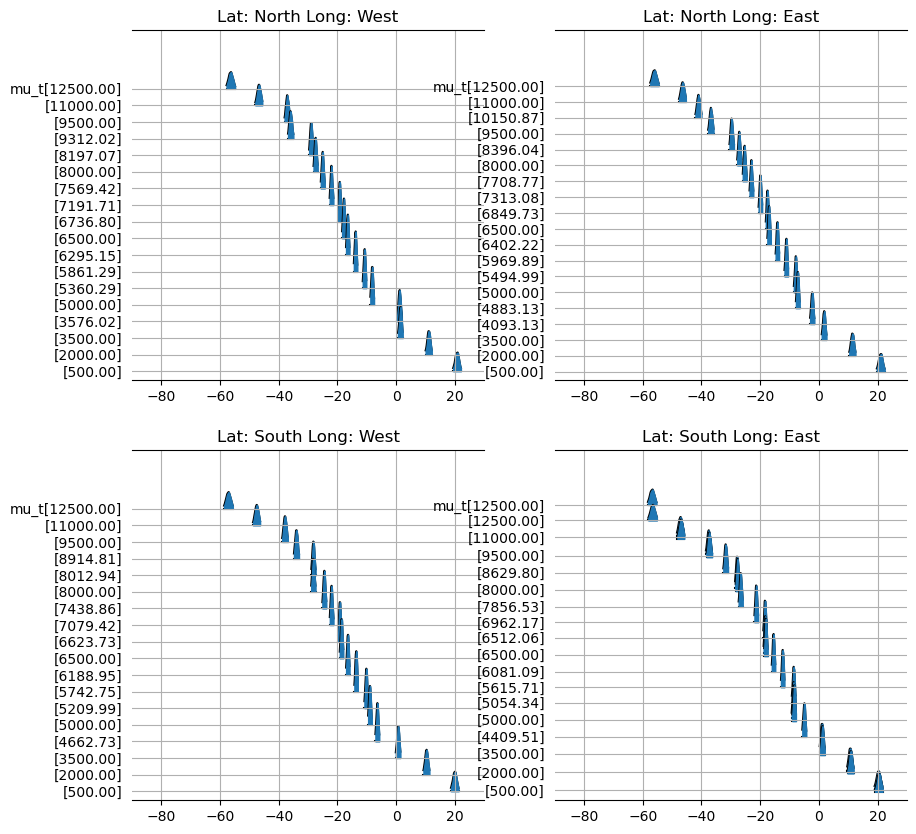

In [340]:
#figures with lat in coulmns and long in rows
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax = ax.flatten()
for i, ((N_S_label,N_S_idx), (E_W_label,E_W_idx)) in enumerate([[i,j] 
                                  for i in [('North',idx_north),('South',idx_south)] 
                                  for j in [('West',idx_west), ('East',idx_east)]]):
    print(N_S_label,E_W_label)
    ax[i].set_title(f'Lat: {N_S_label} Long: {E_W_label}')
    idx = np.intersect1d(N_S_idx,E_W_idx)
    az.plot_forest(idata2.sel(alt_lat_long_time=[x for x in idx_sortby_alt
                                                 if np.any(np.isin(idx,x))]),
                   var_names=['mu_t'],
                   kind='ridgeplot', 
                   combined=True, ax= ax[i],
                   labeller=labeller
                   )
    #align the y axis
    #ax[i].set_ylim(0, 10000)
    ax[i].set_xlim(-90, 30)
    ax[i].grid()


array([<Axes: >], dtype=object)

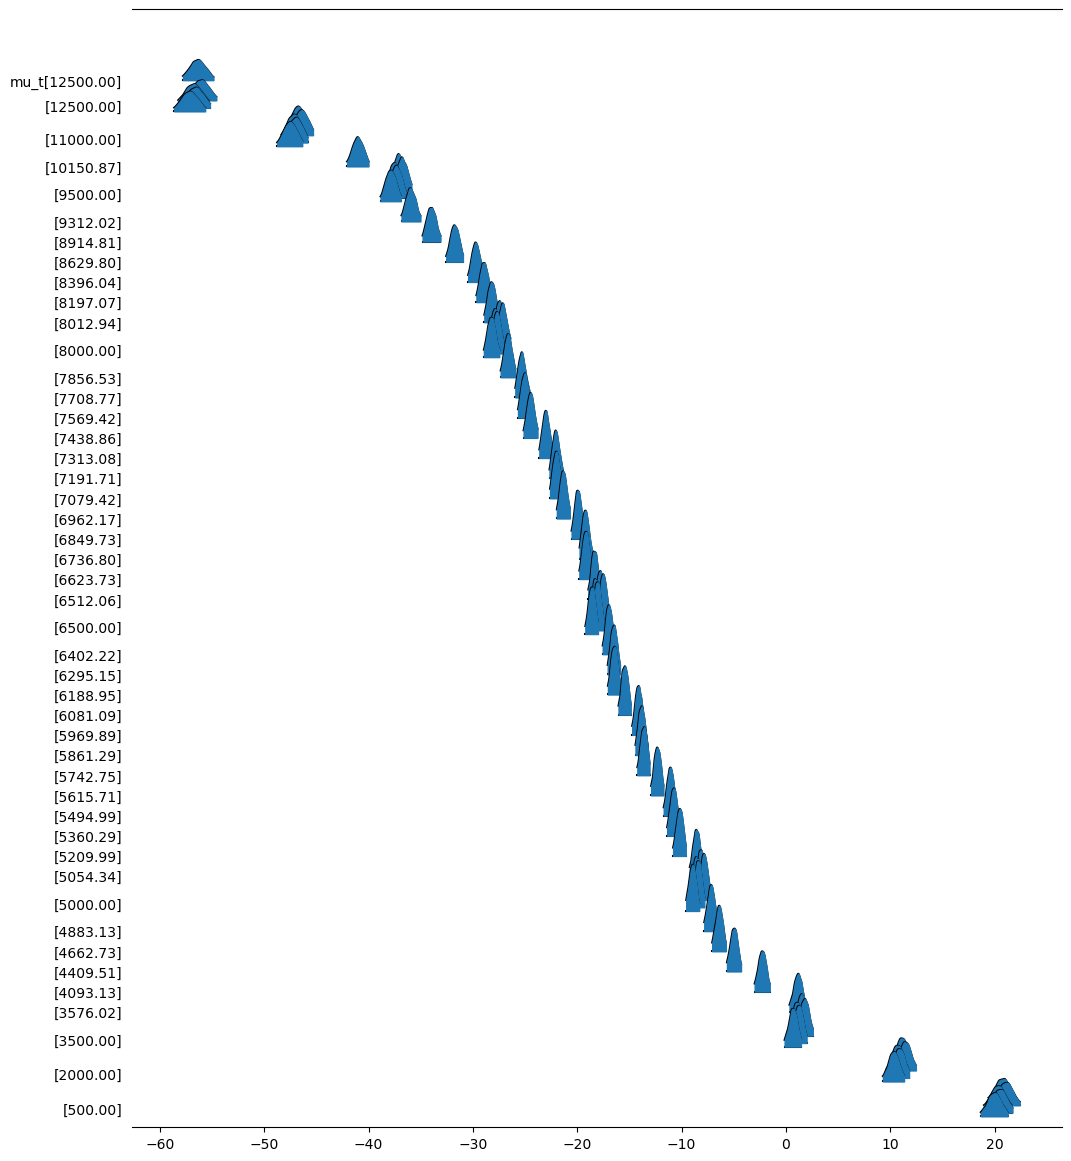

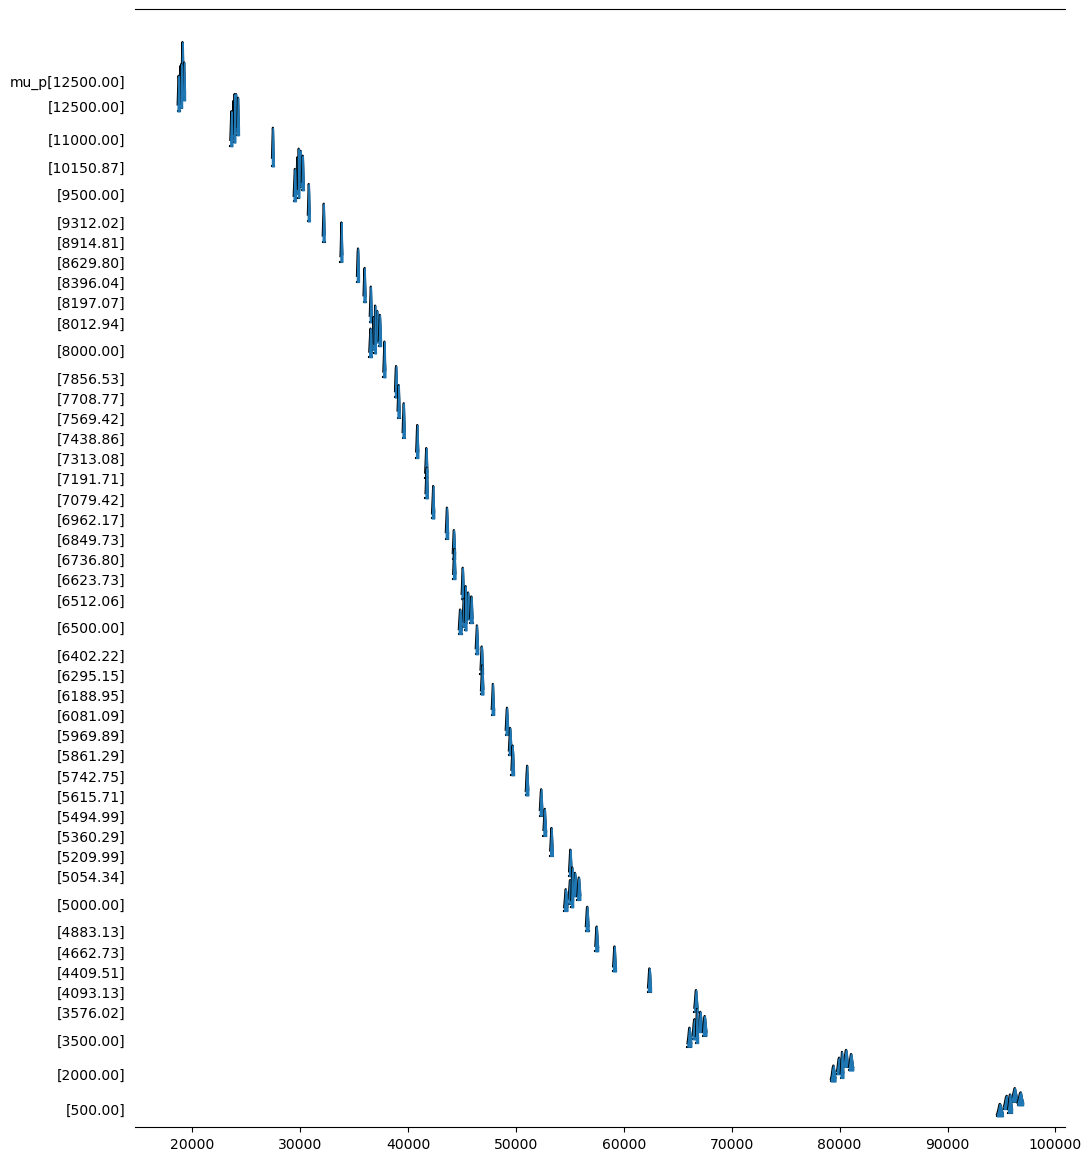

In [341]:
az.plot_forest(idata2.sel( alt_lat_long_time=idx_sortby_alt), var_names=['mu_t'],kind='ridgeplot', combined=True,labeller=labeller)
az.plot_forest(idata2.sel( alt_lat_long_time=idx_sortby_alt), var_names=['mu_p'],kind='ridgeplot', combined=True,labeller=labeller)


c:\Users\willi\OneDrive\Documents\GitHub\Weather\.conda\lib\site-packages\arviz\plots\distcomparisonplot.py:160: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of subplots to plot (360), generating only 40 plots
  warnings.warn(
c:\Users\willi\OneDrive\Documents\GitHub\Weather\.conda\lib\site-packages\arviz\stats\density_utils.py:487: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


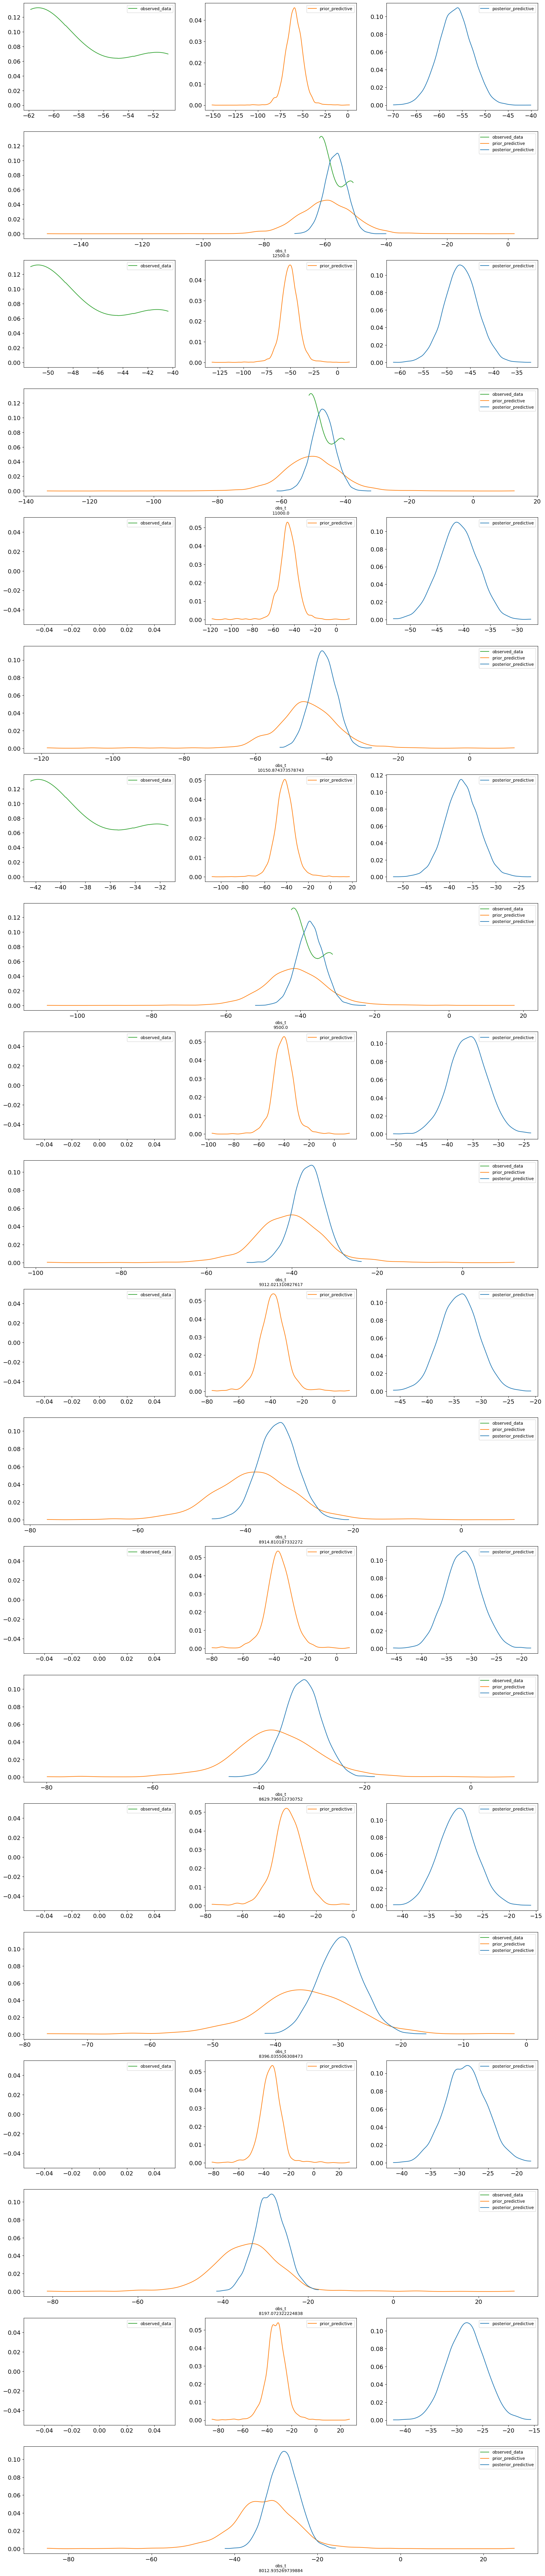

In [342]:
idata_pred_Alt = idata2.map( lambda ds, **kwarg: 
                                   ds.swap_dims(**kwarg).drop('alt_lat_long_time'),#.drop_indexes('Altitude_m'), 
                                   groups=['observed','predictive'], filter_groups='like', 
                                   alt_lat_long_time='Altitude_m')
idata_pred_Alt
az.plot_dist_comparison(idata_pred_Alt, 
                        kind='observed', 
                        #labeller=labeller, 
                        )
plt.show()